In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [5]:
dir_path = '../../data/enrichment/'

In [6]:
os.listdir(dir_path)

['ssgsea_azimuth_ct.csv', 'ssGSEA_zscore.h5ad']

# ANOVA

Загрузим файл псевдобалк экспрессий

In [7]:
file_name = 'ssGSEA_zscore.h5ad'
adata_en_en = sc.read_h5ad(dir_path + file_name)
adata_en_en

AnnData object with n_obs × n_vars = 94 × 340
    obs: 'layer', 'sample_id', 'condition'
    uns: 'condition_colors', 'layer_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [8]:
sc.pp.pca(adata_en_en)

computing PCA
    with n_comps=50
    finished (0:00:00)


Построим PCA

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


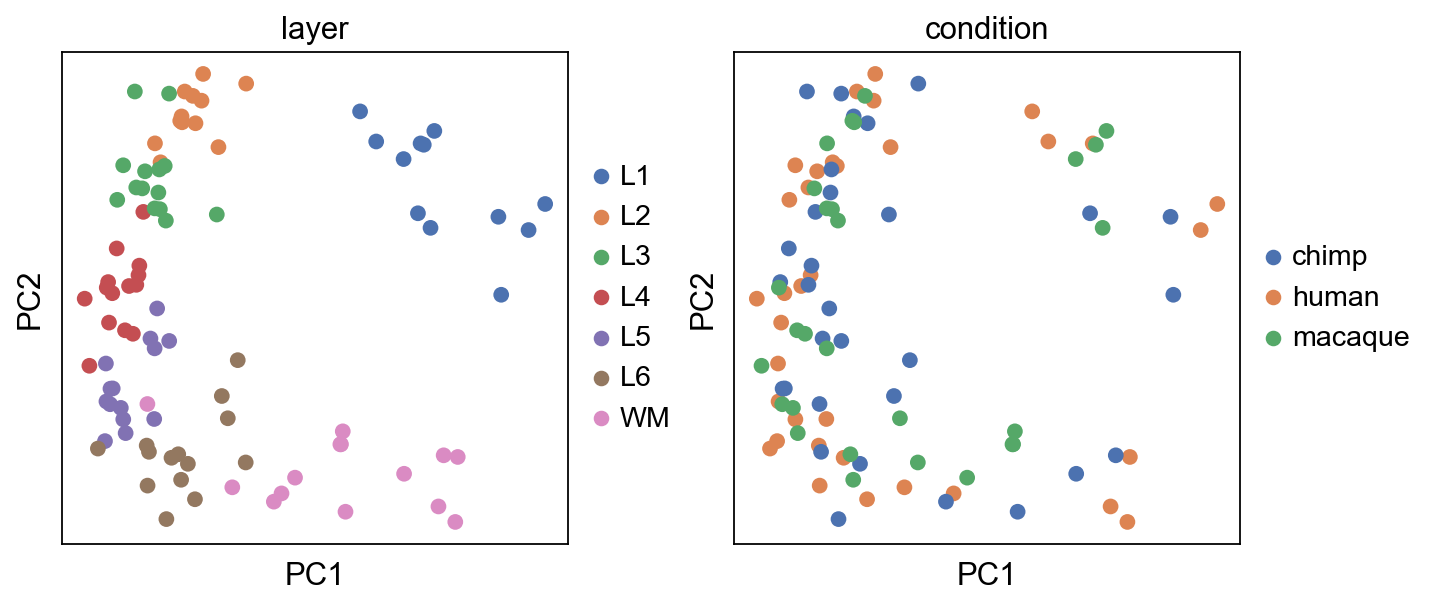

In [9]:
sc.pl.pca(adata_en_en, color=['layer', 'condition'], size=200, ncols=3)

## ANOVA

Сделаем датафрейм с сэмплами для ановы

In [10]:
df = pd.DataFrame(adata_en.X, index=adata_en.obs_names, columns=adata_en.var_names)
df['condition'] = adata_en.obs.condition
df['layer'] = adata_en.obs.layer
df.head()

Term|NES,AXL+ Dendritic Cell CL0000451,AXL+ Myeloid Dendritic Cell CL0000782,AXL+ Plasmacytoid Dendritic Cell CL0000784,Acinar CL0002064,Activated Stellate CL0002410,Adventitial Fibroblast CL0000057,Airway Smooth Muscle UBERON0004225,Alpha Islet Cell CL0000171,Alveolar Epithelial Type 1 CL0002062,Alveolar Epithelial Type 2 CL0002063,...,Vascular Lepotomeningeal Cell CL2000043,Vascular Smooth Muscle CL0000359,Vein UBERON0001638,Vip+ GABAergic Neuron 1 CL0000617,Vip+ GABAergic Neuron 2 CL0000617,Vip+ GABAergic Neuron 3 CL0000617,Vip+ GABAergic Neuron 4 CL0000617,Vip+ GABAergic Neuron CL0000617,condition,layer
WM.human_759,0.319937,-0.513679,1.749483,0.673036,-0.062993,-0.369015,-0.507017,-0.679130,-1.736802,0.208553,...,-0.803623,0.140906,-0.136824,-1.023466,-0.915602,-1.598374,-0.588528,-1.109075,human,WM
WM.human_j12,1.287302,1.238087,-1.641918,-0.799067,1.552774,1.493044,1.580366,-1.541365,0.520593,-0.310020,...,1.352934,1.661841,2.151899,-1.086868,-0.725781,-1.055771,-1.278481,-1.638303,human,WM
WM.human_j3,0.980242,0.474261,-0.133705,-0.093398,1.950841,1.672847,2.031239,1.020566,1.182623,-0.309218,...,1.443587,2.165342,1.157497,-2.102120,0.814861,0.524337,-0.771914,0.031989,human,WM
WM.human_j4,1.390315,1.449872,-1.790560,0.374551,1.699583,1.906769,1.653457,-1.367815,0.651658,-0.264849,...,2.142222,1.957632,2.214458,-1.392049,-1.614621,-1.599062,-0.825982,-1.696934,human,WM
WM.human_j6,-0.269762,-0.182845,-0.667394,-0.254269,-0.160963,0.042216,0.087024,-1.017671,0.752894,0.270021,...,-0.116261,0.110866,-0.157580,-0.564398,0.847917,0.914884,-0.460785,0.166439,human,WM


Заменим названия столбцов на `cell_type{i}` а то `statsmodels` ругается

In [11]:
df_var_num = df.copy()
df_var_num.columns = [f'cell_type{i}' for i in range(1, df_var_num.shape[1] - 1)] + ['condition', 'layer']

Anova для каждого клеточного типа

In [12]:
results = []

for cell_type in tqdm(df_var_num.columns.tolist()[:-2]):
    formula = f'{cell_type} ~ condition + layer + condition:layer'
    model = ols(formula, data=df_var_num).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    results.append(aov_table.loc['condition:layer'].tolist())

# запишем результаты в датасет
columns = ['sum_sq', 'df', 'F', 'PR(>F)']
res = pd.DataFrame(results, columns=columns, index=adata_en.var_names)
res.head()

  0%|          | 0/340 [00:00<?, ?it/s]

,sum_sq,df,F,PR(>F)
Term|NES,,,,
AXL+ Dendritic Cell CL0000451,12.651538,12.0,1.649240,0.096825
AXL+ Myeloid Dendritic Cell CL0000782,12.243486,12.0,1.813330,0.061596
AXL+ Plasmacytoid Dendritic Cell CL0000784,9.442357,12.0,0.891036,0.559672
Acinar CL0002064,16.410512,12.0,1.946963,0.042189
Activated Stellate CL0002410,5.746399,12.0,2.331796,0.013720


## Поправка на множественное сравнение

In [13]:
# поправка на множественые сравнения
mult_test = multipletests(res['PR(>F)'], method='fdr_bh')
res['p_val_adj'] = mult_test[1]
res.to_csv(f'../../results/enrichment/mammals/anova_zscore.csv')

In [14]:
res.head()

,sum_sq,df,F,PR(>F),p_val_adj
Term|NES,,,,,
AXL+ Dendritic Cell CL0000451,12.651538,12.0,1.649240,0.096825,0.141882
AXL+ Myeloid Dendritic Cell CL0000782,12.243486,12.0,1.813330,0.061596,0.098807
AXL+ Plasmacytoid Dendritic Cell CL0000784,9.442357,12.0,0.891036,0.559672,0.592799
Acinar CL0002064,16.410512,12.0,1.946963,0.042189,0.072814
Activated Stellate CL0002410,5.746399,12.0,2.331796,0.013720,0.033680


<AxesSubplot: >

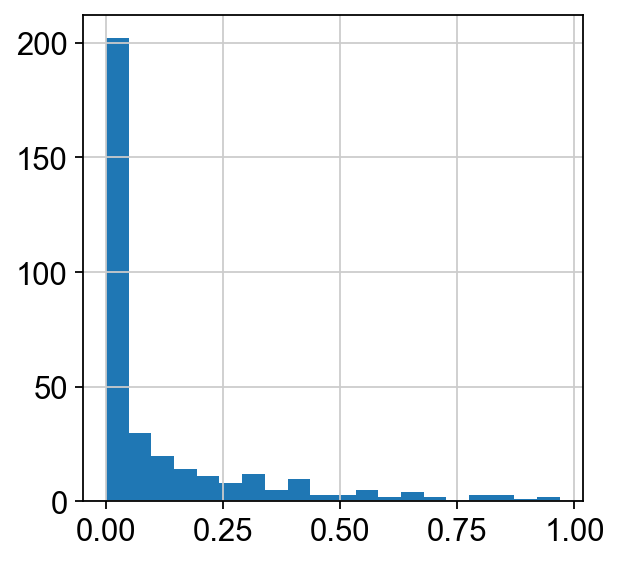

In [15]:
res['PR(>F)'].hist(bins=20)

## t-test

In [16]:
anova_res = pd.read_csv('../../results/enrichment/mammals/anova_zscore.csv', index_col=0)
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
Term|NES,,,,,
AXL+ Dendritic Cell CL0000451,12.651538,12.0,1.649240,0.096825,0.141882
AXL+ Myeloid Dendritic Cell CL0000782,12.243486,12.0,1.813330,0.061596,0.098807
AXL+ Plasmacytoid Dendritic Cell CL0000784,9.442357,12.0,0.891036,0.559672,0.592799
Acinar CL0002064,16.410512,12.0,1.946963,0.042189,0.072814
Activated Stellate CL0002410,5.746399,12.0,2.331796,0.013720,0.033680


Оставим только значимые по взаимодействию гены

In [17]:
sig_cell_types = anova_res[anova_res.p_val_adj < 0.05].index
sig_cell_types

Index(['Activated Stellate CL0002410', 'Airway Smooth Muscle UBERON0004225',
       'Alveolar Epithelial Type 2 CL0002063', 'Alveolar Fibroblast CL0000057',
       'Artery UBERON0001637', 'Astrocyte 1 CL0000127', 'B CL0000236',
       'Basal CL0000646', 'Bronchial Vessel 1 CL0002328',
       'Bronchial Vessel CL0002328',
       ...
       'VIP+ HSPB6+ Layer 1-3 GABAergic Neuron CL0000617',
       'VIP+ HTR3A+ Layer 1-2 GABAergic Neuron CL0000617',
       'VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617',
       'VIP+ SLC7A6OS+ Layer 1-6 GABAergic Neuron CL0000617',
       'VIP+ SMOC1+ Layer 1-5 GABAergic Neuron CL0000617',
       'VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617',
       'VIP+ WNT4+ Layer 1-2 GABAergic Neuron CL0000617',
       'Vascular Smooth Muscle CL0000359', 'Vip+ GABAergic Neuron 2 CL0000617',
       'Vip+ GABAergic Neuron 3 CL0000617'],
      dtype='object', name='Term|NES', length=174)

In [18]:
from itertools import combinations
layers = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']
conditions = ['human', 'chimp', 'macaque']

In [19]:
from scipy.stats import ttest_ind
from itertools import combinations

columns = ['cell_type', 'layer', 'group1', 'group2', 'score', 'pvalue']
results = []


for layer in tqdm(layers):
    layer_results = []
    for group1, group2 in combinations(conditions, 2):
        for cell_type in sig_cell_types.tolist():
            values1 = df.loc[(df['layer'] == layer) & (df['condition'] == group1), cell_type].values
            values2 = df.loc[(df['layer'] == layer) & (df['condition'] == group2), cell_type].values
            ttest_res = ttest_ind(values1, values2)
            layer_results.append([cell_type, layer, group1, group2, ttest_res.statistic, ttest_res.pvalue])
    # поправка на множественное сравнение
    layer_results = pd.DataFrame(layer_results, columns=columns)
    layer_results.dropna(subset='pvalue', inplace=True)
    mult_test = multipletests(layer_results['pvalue'], method='fdr_bh')
    layer_results['p_val_adj'] = mult_test[1]
    results.append(layer_results)

  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
ttest_results = pd.concat(results)
ttest_results

,cell_type,layer,group1,group2,score,pvalue,p_val_adj
0,Activated Stellate CL0002410,L1,human,chimp,-2.055534,0.085584,0.324783
1,Airway Smooth Muscle UBERON0004225,L1,human,chimp,-1.939796,0.100470,0.337251
2,Alveolar Epithelial Type 2 CL0002063,L1,human,chimp,-1.824175,0.117936,0.354689
3,Alveolar Fibroblast CL0000057,L1,human,chimp,-1.380239,0.216734,0.489764
4,Artery UBERON0001637,L1,human,chimp,-1.493480,0.185925,0.438351
...,...,...,...,...,...,...,...
517,VIP+ TAC3+ Layer 3-5 GABAergic Neuron CL0000617,WM,chimp,macaque,1.987182,0.087253,0.222596
518,VIP+ WNT4+ Layer 1-2 GABAergic Neuron CL0000617,WM,chimp,macaque,2.713502,0.030046,0.128560
519,Vascular Smooth Muscle CL0000359,WM,chimp,macaque,1.475525,0.183578,0.342329
520,Vip+ GABAergic Neuron 2 CL0000617,WM,chimp,macaque,0.840469,0.428416,0.596356


In [21]:
ttest_results.to_csv('../../results/enrichment/mammals/ttest_zscore.csv')